# ドルコスト平均法
1. 下がったら買い
2. 一定数ではなく、一定額を買う
> 値段が下がればいっぱい買える。
> 値段が上がれば控えめに買っておく

## ランダムウォークのシリーズを作成

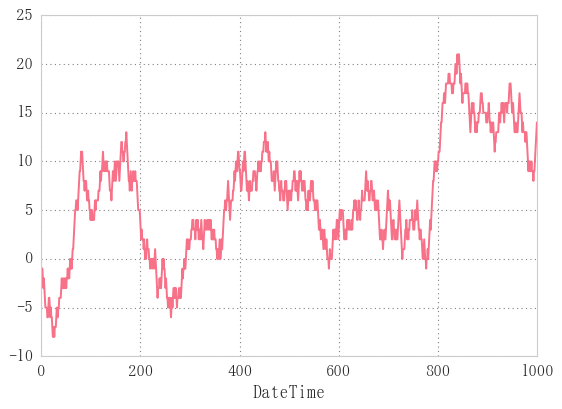

In [22]:
n = 1000
bullbear = pd.Series(np.random.randint(-1, 2, n))
price = bullbear.cumsum()
price.index.name='DateTime'
price.plot()

# 前日より値が低かったら買い、高かったら見過ごし
ドルコスト平均法の(1)

In [23]:
position = np.zeros(len(price))  # priceと同じ長さの配列を作成
for i in price.index[:-1]:
    if price[i+1] - price[i] < 0:  # 前日の値のほうが小さければ高ければ安くなっているということ
        position[i]=price[i]  # そのときのpriceで買い
position[:60]

array([ 0.,  0.,  0., -1., -2.,  0., -2., -3., -4.,  0.,  0.,  0., -5.,
        0.,  0.,  0.,  0., -4., -5.,  0., -5.,  0., -6., -7.,  0.,  0.,
       -7.,  0.,  0.,  0.,  0.,  0., -5.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0., -2.,  0.,  0., -2.,  0.,  0., -2.,  0., -2.,  0.,
        0.,  0., -1.,  0., -1.,  0.,  0.,  0.])

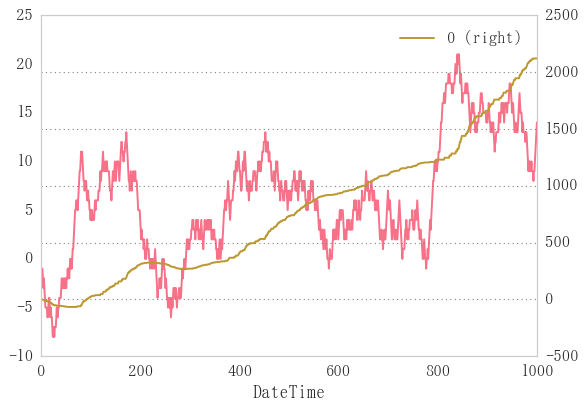

In [24]:
fig, ax = plt.subplots()
price.plot(ax=ax)
pd.DataFrame(position).cumsum().plot(ax=ax, secondary_y=True)  # ポジションのcumulative sumをプロット

## priceからbullbearの計算
priceはbullbearから発生させているが、
実際の日経平均などからはpriceをネット上 のデータとして引っ張ってくるので、 
priceの値からbullbearを計算できるようにする


In [25]:
def p2b(price):
    return price.sub(price.shift(1), fill_value=0)

In [26]:
np.array_equal(p2b(price), np.array(bullbear))

True

`p2b`関数によってbullbearの計算が可能となった。

## 効率化
前日の値より低かった日の終値だけを収集する関数

In [27]:
def dob(price):
    pos = np.zeros(len(price))  # priceと同じ長さの配列を作成
    for i in price.index[:-1]:
        if price[i+1]<price[i]:  # 前日の値より安ければ
            pos[i]=price[i]  # 買い
    return pos

In [28]:
%timeit dob(price)

10 loops, best of 3: 26.3 ms per loop


最もシンプル

In [29]:
%timeit [price[i] if price[i+1]<price[i] else 0 for i in price.index[:-1]]

10 loops, best of 3: 39.8 ms per loop


内包表記を用いても時間はあまり変わらない

In [30]:
def dob2(price):
    pos = np.zeros(len(price))  # priceと同じ長さの配列を作成
    pos = [price[i] if price.sub(price.shift(1), fill_value=0)<0 else 0]  # 下がったら買い
    return pos

In [31]:
price[np.array(bullbear)<0]  # bullbearが負の値になったところだけのpriceを収集

DateTime
0      -1
4      -2
5      -3
7      -3
8      -4
9      -5
13     -6
18     -5
19     -6
21     -6
23     -7
24     -8
27     -8
33     -6
43     -3
46     -3
49     -3
51     -3
55     -2
57     -2
60     -1
62     -1
74      5
82     10
84     10
85      9
86      8
88      7
92      7
93      6
       ..
908    13
912    13
913    12
914    11
925    14
929    15
932    15
933    14
939    15
947    17
948    16
949    15
952    15
953    14
954    13
957    13
965    16
966    15
969    14
970    13
972    13
976    12
979    12
980    11
981    10
982     9
984     9
986     9
989     9
992     8
dtype: int32

In [54]:
def lowprice(price):
    """bullbearが負になったところだけのpriceを収集したpd.Seriesを返す"""
    return price[np.array(p2b(price))<0]

In [33]:
%timeit lowprice(price)

100 loops, best of 3: 3.27 ms per loop


pd.Serieesから直接引き出すので高速。10倍速を実現した

## 可視化
価格(price)と購入した時の額(low)と合計資産(asset)を描画する

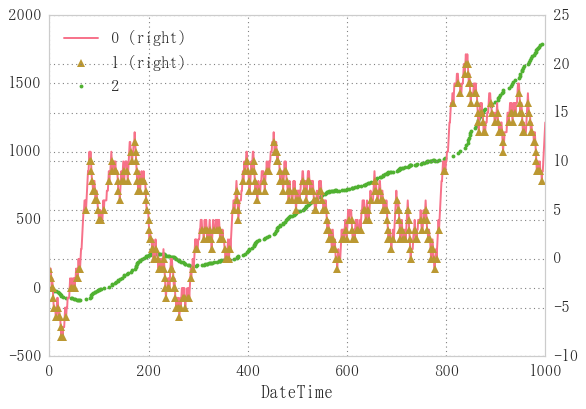

In [34]:
low = lowprice(price)
ax = pd.DataFrame([price, low, low.cumsum()]).T.plot(grid=True, style=['-', '^', '.'], secondary_y=[False, False, True])

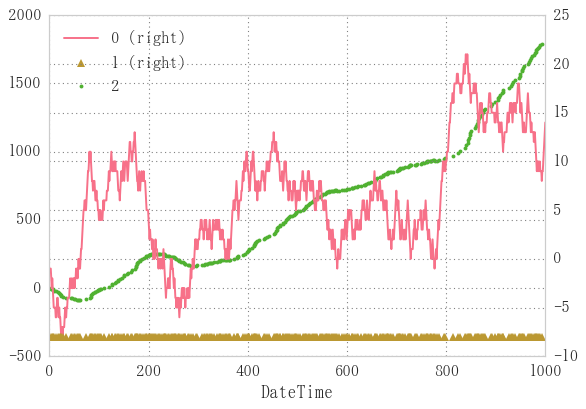

In [35]:
low = lowprice(price)
df = pd.DataFrame([price, pd.Series(np.zeros_like(low)+min(price), index=low.index), low.cumsum()]).T
df.plot(grid=True, style=['-', '^', '.'], secondary_y=[False, False, True])

# 一定金額を買い
ドルコスト平均法の(2)

## ランダムウォークの関数化

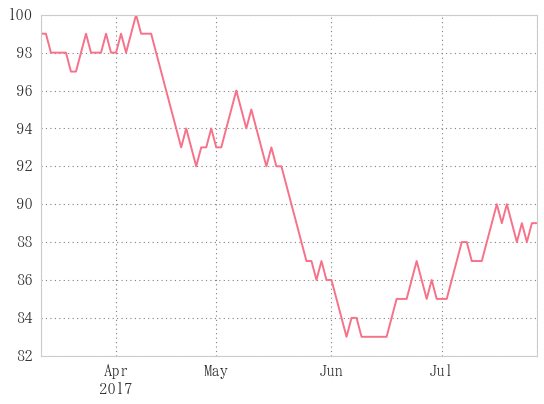

In [36]:
def randomwalk(periods, start=pd.datetime.today().date(), name=None):
    """periods日分だけランダムウォークを返す"""
    ts = pd.date_range(start=start, periods=periods, freq='B')
    bullbear = pd.Series(np.random.randint(-1, 2, periods), index=ts, name=name)
    price = bullbear.cumsum()
    return price
price=randomwalk(100) + 100  # 100は初期値
price.plot()

## 枚数(ticket)の購入

ランダムウォークによる価格変動を再定義。
関数化してみた。

* 縦軸が単位[円]だとする
* 例えば10000円(unit_cost)ずつ買っていくとする
* ~~口数(ticket)の最小口数は1000円~~

In [46]:
unit_cost = 10000
# min_cost = 1000
ticket = unit_cost / price[0]
ticket, int(ticket)

(101.01010101010101, 101)

0インデックス目

In [38]:
tickets = unit_cost / price
pd.DataFrame([price, tickets, tickets.astype(int)],
             index=['price', 'ticket(float)', 'ticket(int)']).T.head()

,price,ticket(float),ticket(int)
2017-03-13,99.0,101.010101,101.0
2017-03-14,99.0,101.010101,101.0
2017-03-15,98.0,102.040816,102.0
2017-03-16,98.0,102.040816,102.0
2017-03-17,98.0,102.040816,102.0


全期間に適用。

切り捨てすると時は`astype(int)`メソッドを使う。

## 一定額ずつ購入していったあとの資産の計算

In [55]:
def dollcost(lowprice, unit_cost):
    """一定額ずつの購入
    引数: 
        price: 購入したときの価格と日付のSeries
        unit_cost: 購入するときの一定金額
    戻り値:
        tickets: 購入したチケット数
    """
    tickets = unit_cost / lowprice
    return tickets.astype(int)

            price  tickets    cost   asset  profit
2017-03-13   99.0      NaN     NaN     NaN     NaN
2017-03-14   99.0      NaN     NaN     NaN     NaN
2017-03-15   98.0    102.0  9996.0  9996.0     0.0
2017-03-16   98.0      NaN     NaN     NaN     NaN
2017-03-17   98.0      NaN     NaN     NaN     NaN


array([<matplotlib.axes._subplots.AxesSubplot object at 0x000001C0DC634630>,
       <matplotlib.axes._subplots.AxesSubplot object at 0x000001C0DDB44860>], dtype=object)

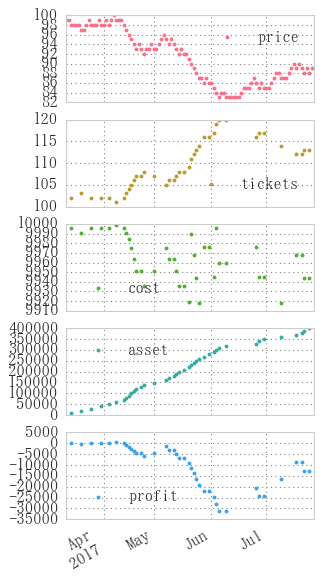

In [56]:
# lowprice関数: 前日より価格が低い時に買いを行った時の時間と価格のSeries返す
# dollcost関数: 一定額ずつの購入
tickets = dollcost(lowprice(price), 10000)
cost = tickets * price
asset = cost.cumsum()
profit = tickets.cumsum() * price - asset

df = pd.DataFrame([price, tickets, cost, asset, profit],
                  index=['price', 'tickets', 'cost', 'asset', 'profit']).T
print(df.head())
df.plot(style='.', subplots=True, figsize=(4,9))

In [57]:
price[-1] * tickets.sum() - cost.sum()  # 最終損益

-8561.0

## 特定期間で買い
毎週毎週購入かけているとお金が大量に必要になってしまう。
そんなに大量のお給料をもらっていないのである程度制限する。
ある週に1回でも購入したら、その週は条件が来ても購入を控えようと思う。

仮に、理想的に毎週の底値で購入できたとする

In [59]:
lowweek = price.resample('W').min()
lowweek[:10]

2017-03-19    98
2017-03-26    97
2017-04-02    98
2017-04-09    98
2017-04-16    97
2017-04-23    93
2017-04-30    92
2017-05-07    93
2017-05-14    93
2017-05-21    91
Freq: W-SUN, dtype: int32

## ticket, cost, assetの計算関数

In [87]:
def profitcalc(price, unit_cost): 
    """購入した価格からプロフィットカーブを計算する
        引数:
            price: 購入価格と日付のSeries
            unit_cost: 購入一定額
        戻り値: price, tickets, cost, asset, profitを入れたdataframe"""
    tickets = dollcost(price, unit_cost)  # dollcost関数: 一定額ずつの購入
    cost = tickets * price
    asset = cost.cumsum()
    profit = tickets.cumsum() * price - asset
    df = pd.DataFrame([price, tickets, cost, asset, profit],
            index=['price', 'tickets', 'cost', 'asset', 'profit']).T
    print('Final Asset: %d'% df.asset[-1])
    print('Final Profit: %d'% df.profit[-1])
    return df

array([<matplotlib.axes._subplots.AxesSubplot object at 0x000001C0DDCED908>,
       <matplotlib.axes._subplots.AxesSubplot object at 0x000001C0DF0D04A8>], dtype=object)

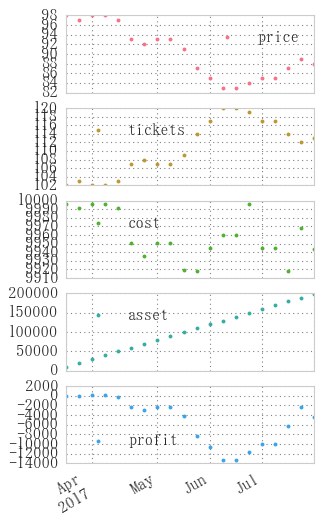

In [64]:
df = profitcalc(lowweek, 10000)
df.head(10)
df.plot(subplots=True, style='.', figsize=[4,8])

In [66]:
df.profit[-1]  # 最終損益

-4433

## 別のランダムウォークで計算

Final Asset: 1993341
Final Profit: -609801


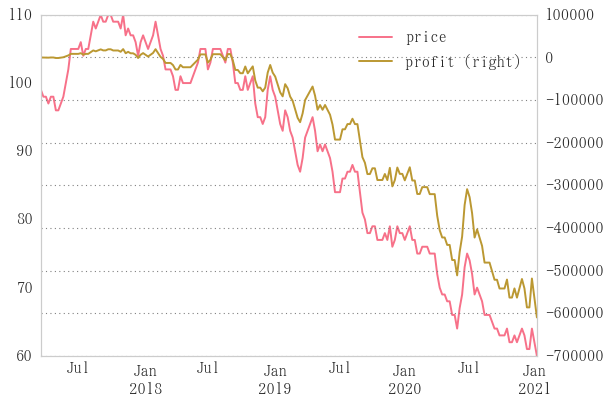

In [99]:
pr = randomwalk(1000) + 100
df = profitcalc(pr.resample('W').min(), unit_cost=10000)
# df.plot(subplots=True, style='.', figsize=[4,8])
df.ix[:, ['price', 'profit']].plot(secondary_y=['profit'])

# 開発中

In [42]:
pd.Period('20170312', 'W')

Period('2017-03-06/2017-03-12', 'W-SUN')

一定期間としてみなすようにコンバートするにはpandas.Periodクラスを使う。

2017/3/12は2017-03-06/2017-03-12の週の間に存在することがわかる。

In [43]:
ts = pd.date_range('20170312', periods=100)
df = pd.DataFrame(np.random.rand(len(ts)), index=ts)
ps = df.asfreq('W', how='end')
ps.head()

,0
2017-03-12,0.154647
2017-03-19,0.872252
2017-03-26,0.056396
2017-04-02,0.895192
2017-04-09,0.888789


週の最後の日の見つけ方がわかった

whileでこの日まで回して、購入行動を行ったらbreakでwhileから抜けるようにする。

In [44]:
def lowprice(price):
    """bullbearが負になったところだけのpriceを収集したpd.Seriesを返す
    ただし、1度購入すると次の週になるまで購入できない"""
    pos = np.zeros_like(price)
    for end in price.index.asfreq('W', how='end'):
        for i in date_range():
            for i in price.index[:-1]:
                if price[i+1] - price[i] < 0:  # 前日の値のほうが小さければ高ければ安くなっているということ
                    position[i]=price[i]  # そのときのpriceで買い
    return price[np.array(p2b(price))<0]

In [45]:
[i for i in price.index.asfreq('W', )]

AttributeError: 'DatetimeIndex' object has no attribute 'asfreq'

In [ ]:
p = pd.Period('20170312', 'W')
p.week